<a href="https://colab.research.google.com/github/axissixa/axissixa/blob/main/simplify_sat_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simplify satellite data
simplify the access and analysis of satellite data from sentinel-2b using available python libraries.

## Dependencies

### Installs
Install dependencies

In [ ]:
!pip install rioxarray
!pip install sentinelsat
!pip install pystac_client
!pip install -U geotable --quiet

###  Imports

In [13]:
import shapely
from shapely.ops import transform
import rioxarray
from sentinelsat import SentinelAPI
from pystac_client import Client
from pyproj import Transformer
import geotable
import folium

### Constants

In [49]:
IMAGE_API = "https://earth-search.aws.element84.com/v0"
MDATA_API = "https://scihub.copernicus.eu/dhus"

LATLONG = 'EPSG:4326'

BAND_DESCRIPTION_DICT = {'visual': 'RGB| 10m',
                          'B01': 'Coastal aerosol |442.7 nm (S2A), 442.3 nm (S2B)| 60m',
                          'B02': 'Blue |492.4 nm (S2A), 492.1 nm (S2B)| 10m',
                          'B03': 'Green |559.8 nm (S2A), 559.0 nm (S2B)| 10m',
                          'B04': 'Red |664.6 nm (S2A), 665.0 nm (S2B)| 10m',
                          'B05': 'Vegetation red edge |704.1nm(S2A), 703.8nm(S2B)| 20m',
                          'B06': 'Vegetation red edge |740.5nm(S2A), 739.1nm(S2B)| 20m',
                          'B07': 'Vegetation red edge |782.8nm(S2A), 779.7nm(S2B)| 20m',
                          'B08': 'NIR |832.8nm(S2A), 833.0nm(S2B)| 10m',
                          'B8A': 'Narrow NIR |864.7nm(S2A), 864.0nm(S2B)| 20m',
                          'B09': 'Water vapour |945.1nm(S2A), 943.2nm(S2B)| 60m',
                          'B11': 'SWIR |1613.7nm(S2A), 1610.4nm(S2B)| 20m',
                          'B12': 'SWIR |2202.4nm(S2A), 2185.7nm(S2B)| 20m',
                          'AOT': 'Aerosol Optical Thickness map, based on Sen2Cor processor|10m',
                          'WVP': 'Water Vapour pressure',
                          'SCL': 'Scene classification data, based on Sen2Cor processor, codelist|20m'
                          }

## Functions

### Query sentinel cogs

In [15]:
def query_stac_with_coordinate(coordinates, max_items=1, time_interval=None, cloud_cover_percent=0, data_coverage_in_tile=70):
    """
    coordinates : shapely Polygon, list of coordinates for an area
    returns : stac.ItemCollection 
    """
    stac_client = Client.open(IMAGE_API)
    sentinel_data_refs = stac_client.search(
        collections=["sentinel-s2-l2a-cogs"],
        intersects=coordinates,
        datetime=time_interval,
        max_items=max_items,
        query={
            "eo:cloud_cover": {"lte": cloud_cover_percent},
            "sentinel:valid_cloud_cover" : {"eq": True},
            "sentinel:data_coverage" : {"gte":data_coverage_in_tile}
        },
        sortby=[
            {
                "field": "properties.sentinel:data_coverage",
                "direction" : "desc"
            }
        ]
    ).get_all_items()
    return sentinel_data_refs


### Query Metadata

In [16]:
def get_metadata_for_tile(id):
    """
     id : filename of stac.Item ex. query_stac_with_coordinate(coords)[0].properties['sentinel:product_id']
     returns : dictionary of metadata items
    """
    
    mdata_api = SentinelAPI('exmachine144', 'technology5D', MDATA_API)
    mdata = mdata_api.query(
        platformname='sentinel-2',
        producttype='S2MSI2A',
        filename=f"{id}"
    )
    return dict(mdata)

### download image as xarray

In [17]:
def download_image(image_url):
  img = rioxarray.open_rasterio(image_url)
  return img

### Crop raster image

In [18]:
def crop_tile_to_poly(image, poly):
    """
     image: xarray/dataarray 
     poly : shapely polygon in (Latitude, longitude) format
     returns : cropped xArray object 
    """
    cropped_img = image.rio.clip_box(*poly.bounds)
    return cropped_img

### transform geometry

In [19]:
#### Buffer a point object to a bounding box around it by deg lat longs
def point_buffer_polygon(point, buffer_deg=0.3):
    return shapely.box(point.buffer(distance=buffer_deg, quad_segs=1).bounds)
    
#### Transform shapely geometry betweem CRSs
def shapely_geo_coordinate_transformation(geometry, source, target):
    t = Transformer.from_crs(source, target, always_xy=True).transform
    return transform(t, geometry)

def point_to_sqbox(center, target, side=1000, source=LATLONG):
    transformed_center = shapely_geo_coordinate_transformation(center, source, target)
    poly = transformed_center.buffer(side)
    return poly

## Shapely geometry manipulation
trying to use multipolygon class and intersections

### polygon set 1

In [20]:
A = shapely.Point(10,10).buffer(2)
B = shapely.Point(15,15).buffer(2)
C = shapely.Point(20,20).buffer(2)
polyset1 = shapely.MultiPolygon([A,B,C])

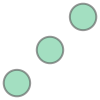

In [21]:
polyset1

### polygon set 2

In [22]:
I = shapely.Point(10,15).buffer(5)
K = shapely.Point(10,9).buffer(1)
J = shapely.Point(18,20).buffer(2)
polyset2 = shapely.MultiPolygon([I,J, K])

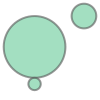

In [23]:
polyset2

### superset

In [24]:
polysuperset = shapely.MultiPolygon([A,B,C, I, J, K])

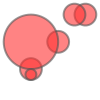

In [25]:
polysuperset

### intersection

In [26]:
test = polyset1.intersection(polyset2)

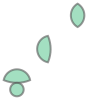

In [27]:
test

## Run

In [28]:
coords = [14.3521, 77.590082]
band = 'visual'
p = shapely.Point(coords[1], coords[0])
cog_url_dict = query_stac_with_coordinate(p).items[0].assets

In [30]:
img = download_image(cog_url_dict[band].href)
pp_box = point_to_sqbox(p, img.rio.crs, 4000)
l = point_to_sqbox(p, img.rio.crs, 100)

In [31]:
cropped_img = crop_tile_to_poly(img, pp_box)

### Single crop on visual

In [ ]:
cropped_img.rio.to_raster("test.png")

In [ ]:
import matplotlib.pyplot as plt

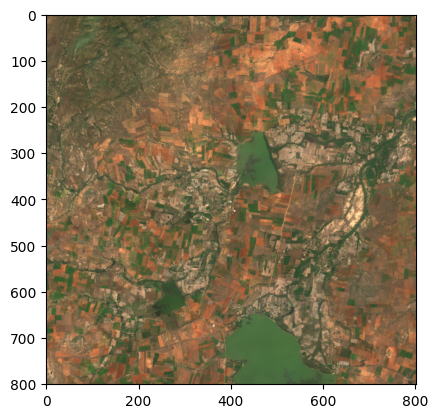

In [ ]:
plt.imshow(cropped_img.transpose('y','x','band'))

### Build folium map

In [7]:
def download_img_and_crop(band, urls, poly):
  array = download_image(urls[band].href)
  cropped_array = crop_tile_to_poly(array, poly)
  return cropped_array

In [36]:
cropped = {}
for key in cog_url_dict.keys():
  if key not in set(['metadata', 'thumbnail', 'overview', 'info']):
    cropped[key] = download_img_and_crop(key, cog_url_dict, pp_box)

In [ ]:
cropped['SCL'].shape

(1, 201, 201)

In [38]:
for key in cropped.keys():
  cropped[key].rio.to_raster(f"{key}.tif")

In [8]:
from google.colab import drive
drive.mount('/content/drive')
data_folder_path = '/content/drive/MyDrive/HSI/Anantgram/dataset/'

Mounted at /content/drive


In [9]:
from glob import glob
import os
data_file_list = glob(os.path.join(data_folder_path, '*'))

In [29]:
phase1 = shapely.wkt.loads(geotable.load('/content/drive/MyDrive/HSI/Anantgram/vectors/all_phases/phase_1.kmz', drop_z=True).geometries[0].wkt)
phase2 = shapely.wkt.loads(geotable.load('/content/drive/MyDrive/HSI/Anantgram/vectors/all_phases/phase_2.kmz', drop_z=True).geometries[0].wkt)
phase3 = shapely.wkt.loads(geotable.load('/content/drive/MyDrive/HSI/Anantgram/vectors/all_phases/phase_3.kmz', drop_z=True).geometries[0].wkt)
phase4 = shapely.wkt.loads(geotable.load('/content/drive/MyDrive/HSI/Anantgram/vectors/all_phases/phase_ff.kmz', drop_z=True).geometries[0].wkt)
water = shapely.wkt.loads(geotable.load('/content/drive/MyDrive/HSI/Anantgram/vectors/all_phases/water_body_anantgram.kmz', drop_z=True).geometries[0].wkt)

In [41]:
print(phase1)

POLYGON ((77.59028218796595 14.35046105688027, 77.5907078797237 14.35141953963847, 77.59080668538186 14.35265458668058, 77.58878677427663 14.35287909371771, 77.58865420973582 14.35104670485609, 77.58761600116105 14.35123030403156, 77.58579268010216 14.35071109944532, 77.58597221953039 14.34950942363161, 77.58645223929486 14.34865540052318, 77.58708181749219 14.34860067061226, 77.58774477580639 14.34894913784571, 77.58786622697944 14.3477185463384, 77.58908245040118 14.34762597449603, 77.5914297868586 14.35015477492837, 77.59028218796595 14.35046105688027))


In [32]:
b = shapely_geo_coordinate_transformation(shapely.box(*cropped_img.rio.bounds()), cropped_img.rio.crs, LATLONG).bounds

In [33]:
import rasterio

In [54]:
import matplotlib

In [63]:
m = folium.Map(location=coords, min_zoom= 13, zoom_start=14, height='60%', width='80%', control_scale=True)

folium.GeoJson(data=phase1, tooltip="Phase 1", name="Phase 1").add_to(m)
folium.GeoJson(data=phase2, tooltip="Phase 2", name="Phase 2").add_to(m)
folium.GeoJson(data=phase3, tooltip="Phase 3", name="Phase 3").add_to(m)
folium.GeoJson(data=phase4, tooltip="Phase 4", name="Phase 4").add_to(m)
folium.GeoJson(data=water, tooltip="Water", name="Water").add_to(m)
m.add_child(folium.LatLngPopup())
for key in cropped.keys():
  with rasterio.open(f'{key}.tif') as src:
    im = src.read()
  if key == 'visual':
    op = 1
    sh = True
  else:
    op = 0.8
    sh = False

  img = folium.raster_layers.ImageOverlay(
    name=BAND_DESCRIPTION_DICT[key],
    image=im.transpose(1, 2, 0),
    bounds=[[b[1], b[0]], [b[3], b[2]]],
    opacity=op,
    interactive=True,
    cross_origin=False,
    zindex=1,
    show=sh,
  )
  img.add_to(m)
folium.LayerControl().add_to(m)

### Folium Map Visual


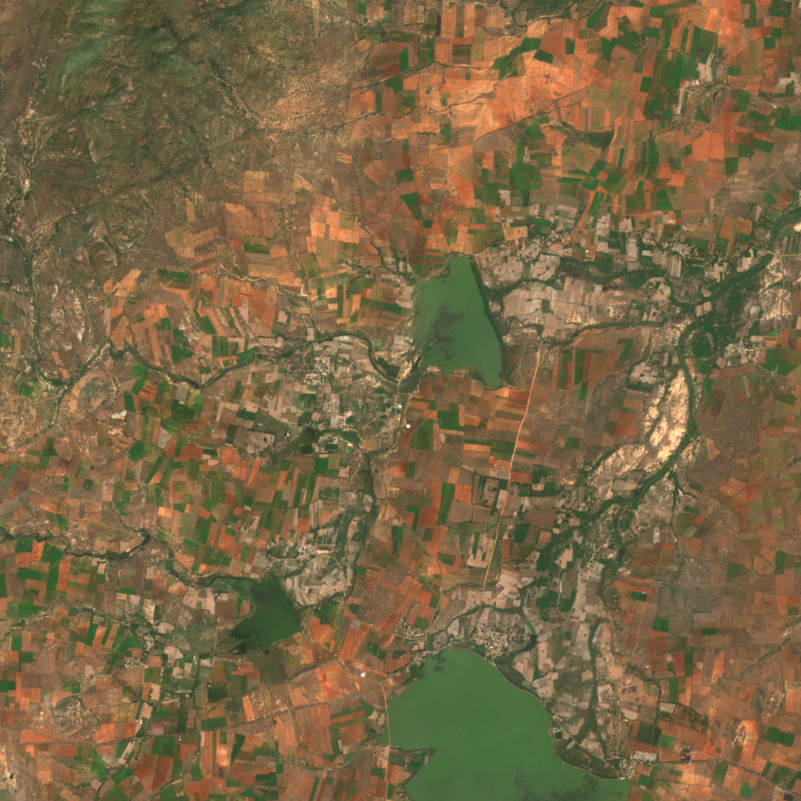
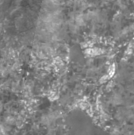
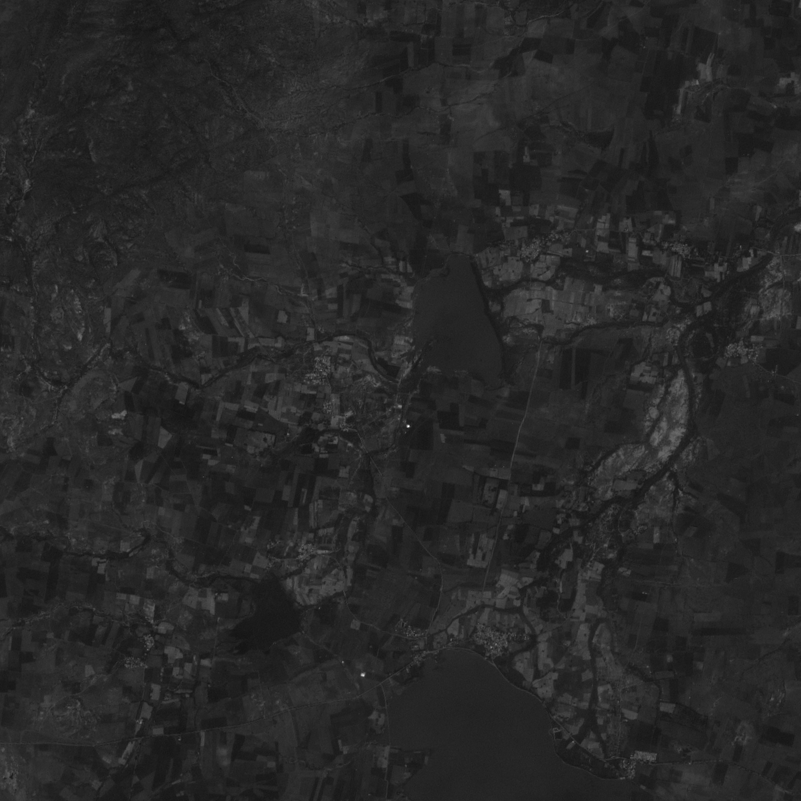
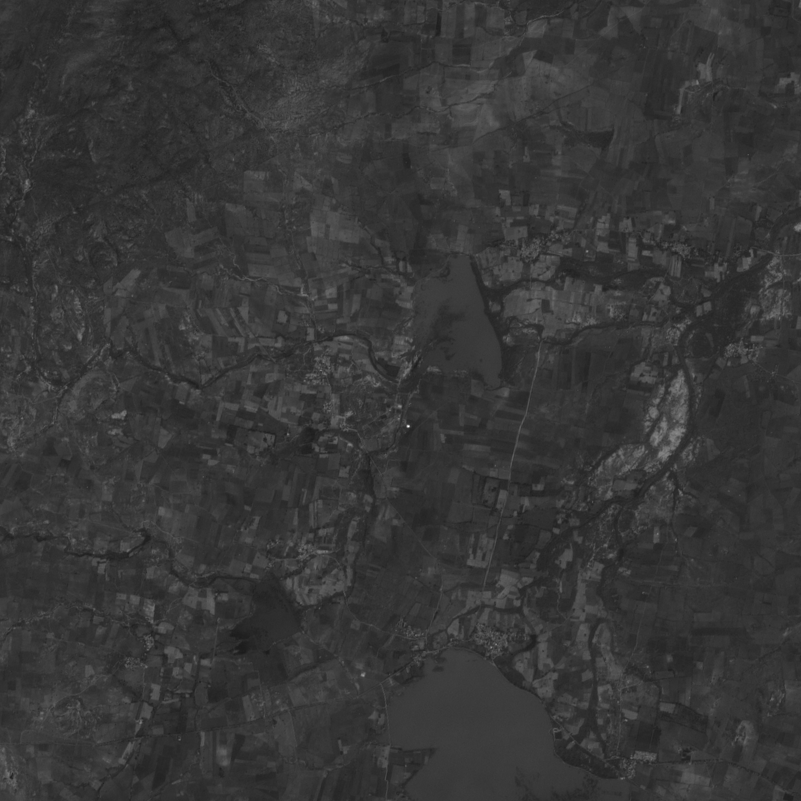
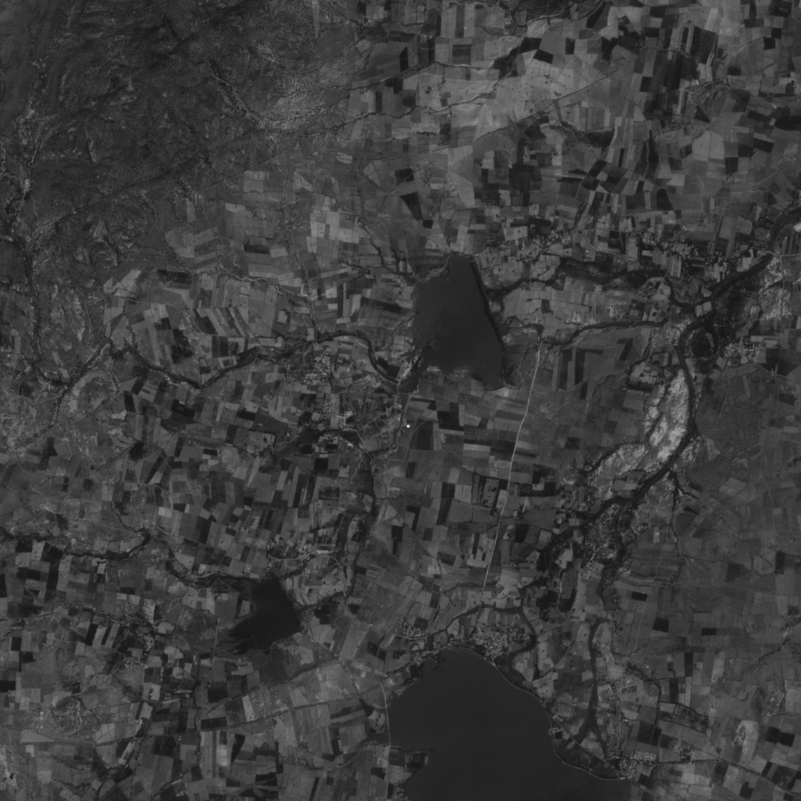
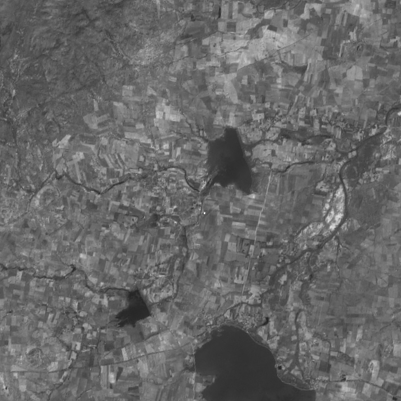
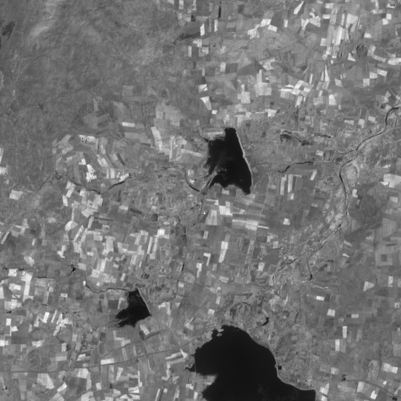
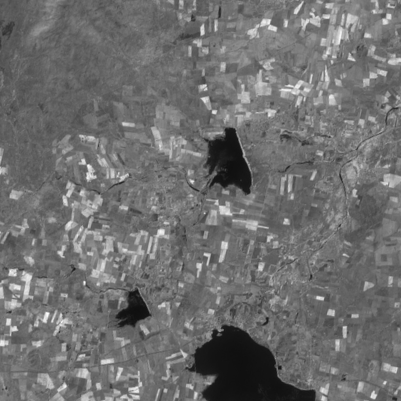
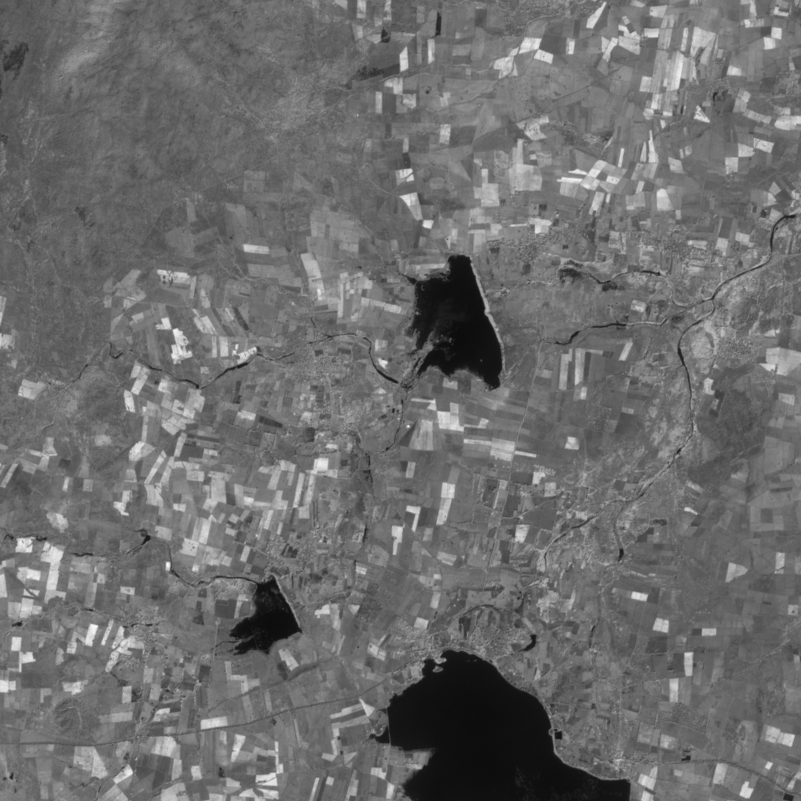
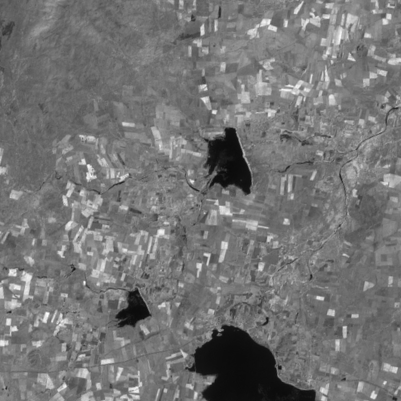
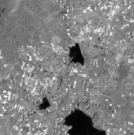
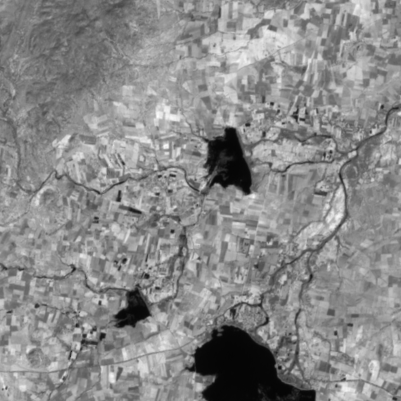
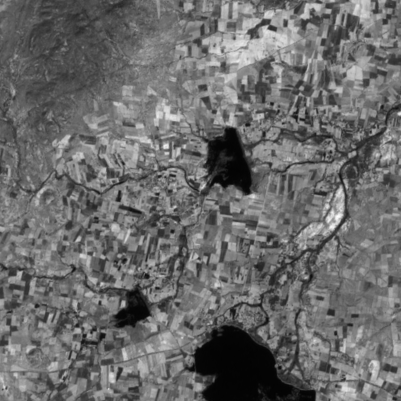
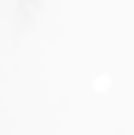
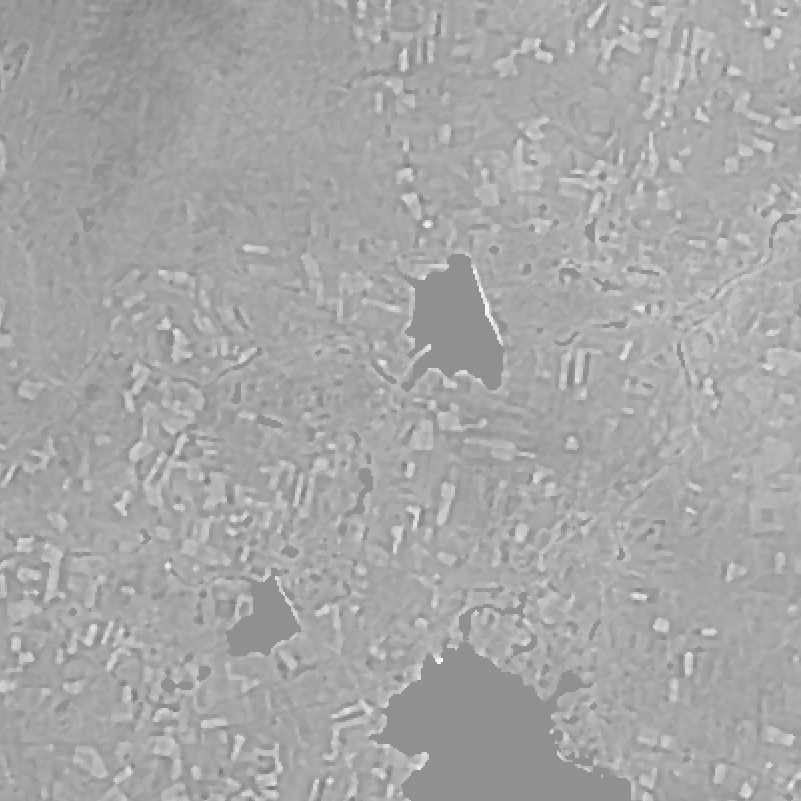
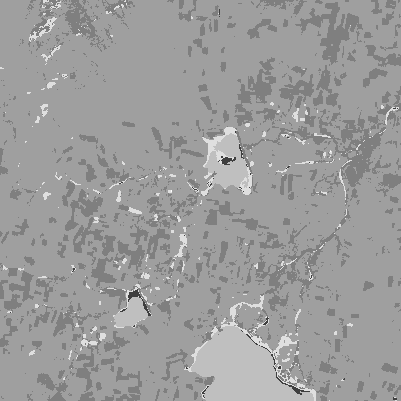

In [64]:
m

In [ ]:
ndvi = (cropped['B08']-cropped['B04'])/(cropped['B08']+cropped['B04'])